# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans

# Importing dataset

In [2]:
df= pd.read_csv('customer_shopping_data.csv')

# Basic information

In [3]:
df.sample(5)

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
23931,I194533,C321300,Female,58,Clothing,1,300.08,Credit Card,23/07/2021,Istinye Park
40347,I191884,C120058,Female,28,Toys,1,35.84,Debit Card,27/09/2021,Kanyon
4851,I219678,C594535,Male,61,Cosmetics,3,121.98,Debit Card,11/3/2021,Zorlu Center
38489,I252620,C295002,Male,68,Toys,3,107.52,Cash,7/1/2022,Mall of Istanbul
68802,I258874,C147028,Female,33,Books,4,60.60,Debit Card,3/8/2021,Cevahir AVM


In [4]:
df.shape

(99457, 10)

In [5]:
list(df.columns)

['invoice_no',
 'customer_id',
 'gender',
 'age',
 'category',
 'quantity',
 'price',
 'payment_method',
 'invoice_date',
 'shopping_mall']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [7]:
df.isnull().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
shopping_mall     0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,99457.0,43.427089,14.990054,18.00,30.00,43.0,56.00,69.0
quantity,99457.0,3.003429,1.413025,1.00,2.00,3.0,4.00,5.0
price,99457.0,689.256321,941.184567,5.23,45.45,203.3,1200.32,5250.0


In [10]:
df[['age', 'quantity', 'price']].agg(['skew', 'kurtosis']).T

,skew,kurtosis
age,0.009021,-1.198354
quantity,-0.001296,-1.295893
price,2.247433,6.168350


### Deductions based on first glance:
    1. Dataset is fairly big in size with over 99000 rows and 10 columns.
    2. Columns in datset are self-explanatory.
    3. We might need to change datatypes of some attributes before implementing ML algorithms.
    4. There is no null value in the datset.
    5. There is no duplicate entries in the dataset.
    6. Age and Price attributes is fairly distributed. Will do further analysis regarding this.

# EDA

## Univariate analysis

In [11]:
df['customer_id'].nunique()

99457

In [12]:
df['gender'].value_counts()

Female    59482
Male      39975
Name: gender, dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

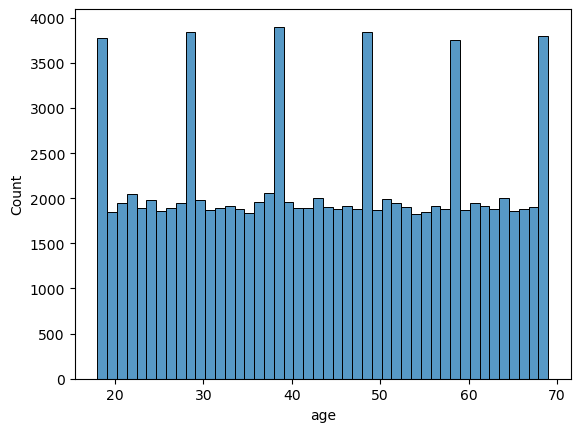

In [13]:
sns.histplot(df['age'])

In [14]:
df['category'].nunique()

8

In [15]:
df['category'].value_counts()

Clothing           34487
Cosmetics          15097
Food & Beverage    14776
Toys               10087
Shoes              10034
Souvenir            4999
Technology          4996
Books               4981
Name: category, dtype: int64

In [16]:
df['payment_method'].nunique()

3

In [17]:
df['payment_method'].value_counts()

Cash           44447
Credit Card    34931
Debit Card     20079
Name: payment_method, dtype: int64

In [18]:
df['shopping_mall'].value_counts()

Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: shopping_mall, dtype: int64

<AxesSubplot:xlabel='price', ylabel='Count'>

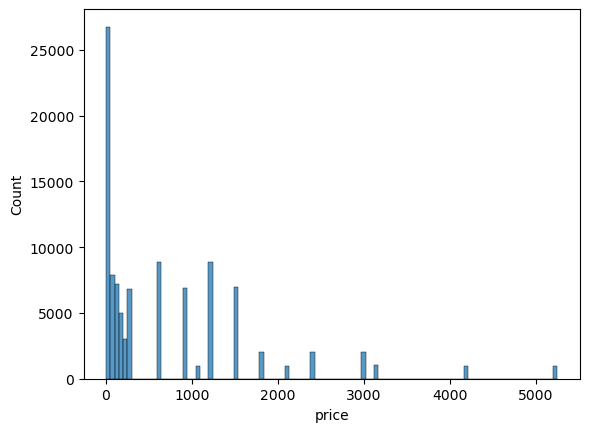

In [19]:
sns.histplot(df['price'])

#### Let's change invoice date to datetime and examine it.

In [20]:
df['invoice_date']=df['invoice_date'].astype('datetime64[ns]')

In [52]:
df['invoice_year']= df['invoice_date'].dt.year
df['invoice_month']=df['invoice_date'].dt.month
df['invoice_weekday']= df['invoice_date'].dt.weekday
dw_mapping={
    1: 'Monday', 
    2: 'Tuesday', 
    3: 'Wednesday', 
    4: 'Thursday', 
    5: 'Friday',
    6: 'Saturday', 
    0: 'Sunday'
}
df['dayofweek']= df['invoice_date'].dt.weekday.map(dw_mapping)

In [22]:
df['invoice_year'].value_counts()

2022    45551
2021    45382
2023     8524
Name: invoice_year, dtype: int64

<AxesSubplot:xlabel='invoice_month', ylabel='Count'>

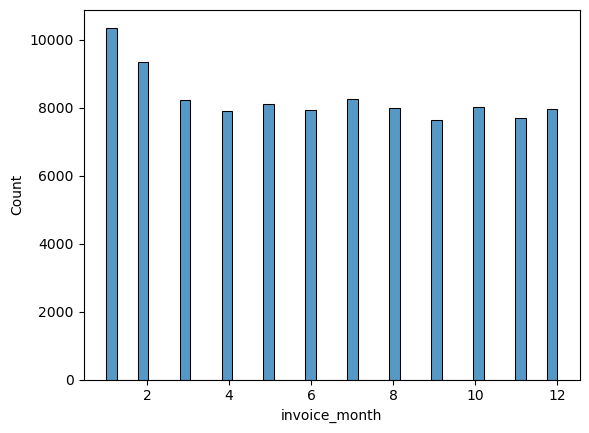

In [23]:
sns.histplot(df['invoice_month'])

<AxesSubplot:title={'center':'Days having most transactions'}, xlabel='day', ylabel='Number of transaction'>

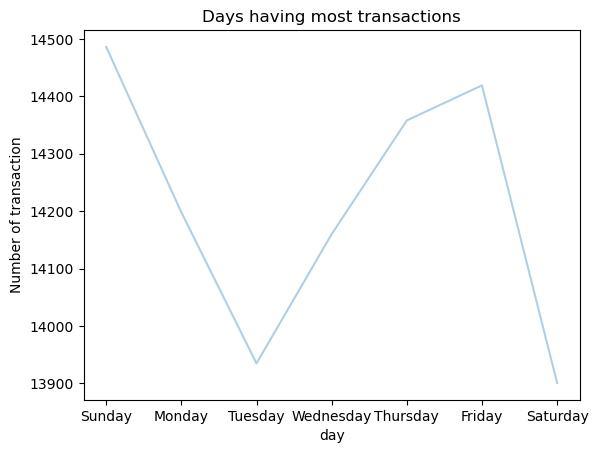

In [55]:
df_sorted_weekday = df.sort_values(['invoice_weekday'], ascending=True, axis=0, inplace=False)
ax = df_sorted_weekday['dayofweek'].value_counts()\
[df_sorted_weekday['dayofweek'].unique()]\
.plot(kind='line',alpha=0.35)
ax.set_title('Days having most transactions')
ax.set_ylabel('Number of transaction')
ax.set_xlabel('day')
ax

### Deductions based on univariate analysis:
    1. There are more female customers than male customers. And the difference is significant.
    2. Age is almost uniformly distributed with a few spikes here and there.
    3. Shopping for clothes is the highest, almost 34% of total shopping is done in clothes segment.
    4. Cosmetics, food & beverages, toys and shoes are second, third, fourth and fifth on the list respectively.
    5. Books are the least bought item.
    6. Cash is the most frequent method of payment, which seems counter-intuitive because the data is not very old.
    7. Mall of Istanbul and Kanyon are the most visited malls.
    8. Emaar square mall is the least visited mall.
    9. High priced items are bought less frequently, which is normal.
    10. January has the most number of customers.

## Bivariate analysis

In [24]:
df.groupby('gender')['age'].mean()

gender
Female    43.453515
Male      43.387767
Name: age, dtype: float64

In [25]:
df.groupby('gender')['price'].mean()

gender
Female    688.137615
Male      690.920933
Name: price, dtype: float64

In [26]:
df.groupby('category')['gender'].value_counts()

category         gender
Books            Female     2906
                 Male       2075
Clothing         Female    20652
                 Male      13835
Cosmetics        Female     9070
                 Male       6027
Food & Beverage  Female     8804
                 Male       5972
Shoes            Female     5967
                 Male       4067
Souvenir         Female     3017
                 Male       1982
Technology       Female     2981
                 Male       2015
Toys             Female     6085
                 Male       4002
Name: gender, dtype: int64

In [27]:
df.groupby('category')['age'].mean()

category
Books              43.541859
Clothing           43.409227
Cosmetics          43.580645
Food & Beverage    43.354426
Shoes              43.454953
Souvenir           43.393079
Technology         43.368495
Toys               43.326262
Name: age, dtype: float64

In [28]:
df.groupby('category')['price'].mean()

category
Books                45.568621
Clothing            901.084021
Cosmetics           122.448626
Food & Beverage      15.671948
Shoes              1807.388568
Souvenir             34.894345
Technology         3156.935548
Toys                107.733185
Name: price, dtype: float64

In [29]:
df.groupby('category')['price'].sum()

category
Books                226977.30
Clothing           31075684.64
Cosmetics           1848606.90
Food & Beverage      231568.71
Shoes              18135336.89
Souvenir             174436.83
Technology         15772050.00
Toys                1086704.64
Name: price, dtype: float64

In [30]:
df.groupby('payment_method')['gender'].value_counts()

payment_method  gender
Cash            Female    26509
                Male      17938
Credit Card     Female    21011
                Male      13920
Debit Card      Female    11962
                Male       8117
Name: gender, dtype: int64

In [31]:
df.groupby('shopping_mall')['gender'].value_counts()

shopping_mall      gender
Cevahir AVM        Female     2940
                   Male       2051
Emaar Square Mall  Female     2842
                   Male       1969
Forum Istanbul     Female     3016
                   Male       1931
Istinye Park       Female     5874
                   Male       3907
Kanyon             Female    11906
                   Male       7917
Mall of Istanbul   Female    11902
                   Male       8041
Metrocity          Female     8941
                   Male       6070
Metropol AVM       Female     6144
                   Male       4017
Viaport Outlet     Female     2949
                   Male       1965
Zorlu Center       Female     2968
                   Male       2107
Name: gender, dtype: int64

In [32]:
df.groupby('shopping_mall')['age'].mean()

shopping_mall
Cevahir AVM          43.172511
Emaar Square Mall    43.561630
Forum Istanbul       43.537497
Istinye Park         43.383601
Kanyon               43.498966
Mall of Istanbul     43.440455
Metrocity            43.499301
Metropol AVM         43.212873
Viaport Outlet       43.298942
Zorlu Center         43.532217
Name: age, dtype: float64

In [33]:
df.groupby('shopping_mall')['price'].mean()

shopping_mall
Cevahir AVM          687.972719
Emaar Square Mall    704.720081
Forum Istanbul       674.363012
Istinye Park         686.747525
Kanyon               691.658944
Mall of Istanbul     694.566395
Metrocity            682.831262
Metropol AVM         682.806120
Viaport Outlet       694.753655
Zorlu Center         691.556457
Name: price, dtype: float64

In [34]:
df.groupby('invoice_year')['price'].sum()

invoice_year
2021    31316304.63
2022    31372826.18
2023     5862235.10
Name: price, dtype: float64

In [35]:
df.groupby(by=['invoice_month'])['price'].sum()

invoice_month
1     7074408.23
2     6529899.50
3     5689336.60
4     5514264.38
5     5615779.68
6     5504522.30
7     5673187.14
8     5413449.27
9     5268690.41
10    5674237.18
11    5120403.96
12    5473187.26
Name: price, dtype: float64

### Deductions based on bivariate analysis:
    1. Average age for male and female customers is same.
    2. Average money spent has no significant difference based on gender of the customer.
    3. Technology is the segment where average cost is the highest.
    4. Average cost of shoes are more than the average cost of clothes.
    5. Clothes, shoes and technology generates a major chunck of the revenue.
    6. Average cost of items at Emaar Square Mall is higher than other malls. This can be the reason of it being the least          visited mall.
    7. Sale has risen in 2022 as compared to 2021.
    8. Sale is January is the highest.

# RFM Analysis

## Recency

In [36]:
today='01/01/2024'
today=pd.to_datetime(today)

In [37]:
df_r=df.groupby(by='customer_id').agg({'invoice_date': lambda x: (today-x.max()).days})
df_r.columns=['Recency']
df_r.sample(5)

,Recency
customer_id,
C149139,471
C270478,1019
C321995,563
C142858,418
C300927,877


## Frequency

In [38]:
df_f=df.drop_duplicates('invoice_no').groupby(by=['customer_id'])[['invoice_no']].count()
df_f.columns=['Frequency']
df_f.sample(5)

,Frequency
customer_id,
C148202,1
C158844,1
C536056,1
C285910,1
C468195,1


## Monetary

In [39]:
df['Total Price']=df['quantity']*df['price']
df_m=df.groupby(by=['customer_id'])[['Total Price']].sum()
df_m.columns=['Monetary']
df_m.sample(5)

,Monetary
customer_id,
C228396,40.66
C648964,1200.32
C121560,47.07
C204729,1050.00
C221813,300.08


In [40]:
df_rfm=pd.concat([df_r,df_f,df_m], axis=1)

In [41]:
df_rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
C100004,766,1,7502.00
C100005,304,1,2400.68
C100006,719,1,322.56
C100012,869,1,130.75
C100019,890,1,35.84


In [42]:
df_rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,99457.0,691.020270,239.610727,30.00,497.00,695.00,896.00,1095.0
Frequency,99457.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.0
Monetary,99457.0,2528.789268,4222.475781,5.23,136.35,600.17,2700.72,26250.0


### Deductions based on RFM analysis:
    1. Recency scores appear to be fairly distributed.
    2. Frequency score for every invoice_id is one. Which is not a very good sign.
    3. Monetory scores are distributed. Standard deviation is huge.

# Customer segmentation using K-means clustering based on RFM analysis

In [43]:
ss=StandardScaler()
rfm_scaled=ss.fit_transform(df_rfm)

In [44]:
rfm_scaled=pd.DataFrame(rfm_scaled)

In [45]:
distortions = []
K = range(1,10)
for k in K:
    kmc = KMeans(n_clusters=k)
    kmc.fit(rfm_scaled)
    distortions.append(kmc.inertia_)

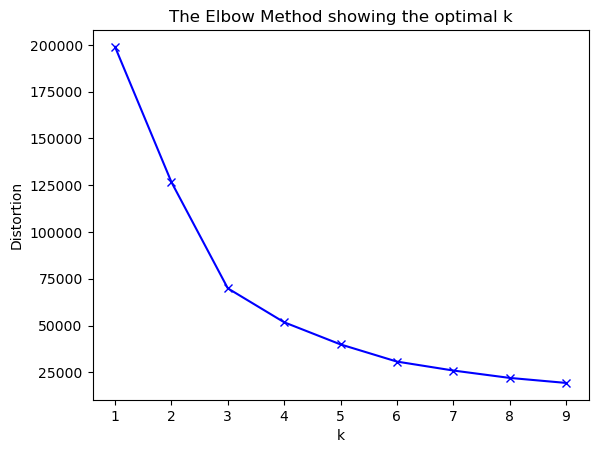

In [46]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [47]:
kmc = KMeans(n_clusters=3)
kmc.fit(rfm_scaled)

KMeans(n_clusters=3)

In [48]:
df_rfm["Cluster_No_kmc"] = (kmc.labels_ + 1)

In [49]:
df_rfm.groupby(["Cluster_No_kmc"])[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster_No_kmc,,,
1,893.970209,1.0,1302.429295
2,697.200173,1.0,11760.028358
3,477.502152,1.0,1321.474226


In [50]:
df_rfm.groupby(["Cluster_No_kmc"])[["Recency", "Frequency", "Monetary"]].median()

,Recency,Frequency,Monetary
Cluster_No_kmc,,,
1,897.0,1.0,365.94
2,700.0,1.0,9602.72
3,486.0,1.0,365.94


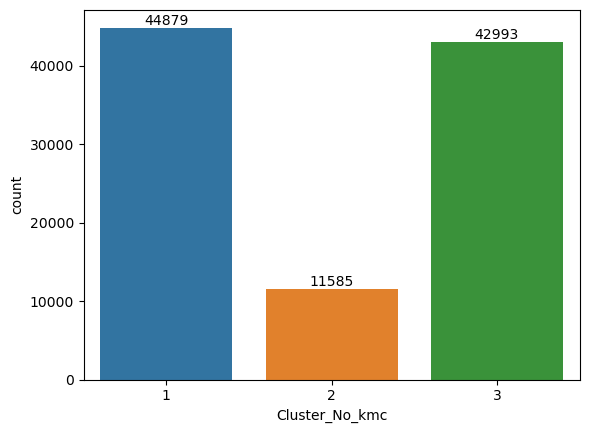

In [51]:
ax=sns.countplot(df_rfm['Cluster_No_kmc'])
for bars in ax.containers:
    ax.bar_label(bars)

### Conclusions:
    1. The mean and median of Monetory column of two clusters are very close.
    2. Average Recency of all the clusters are easily distinguishable.
    3. Count of two clusters are close.
    4. Count of one cluster is very less as compared to other clusters, which seems accurate because these are the people          who spend more money.